In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# !unzip gdrive/MyDrive/data.zip

Archive:  gdrive/MyDrive/data.zip
mapname:  conversion of  failed
 extracting: FBP128_batch1.npy.gz    
 extracting: FBP128_batch2.npy.gz    
 extracting: FBP128_batch3.npy.gz    
 extracting: FBP128_batch4.npy.gz    
 extracting: Phantom_batch1.npy.gz   
 extracting: Phantom_batch2.npy.gz   
 extracting: Phantom_batch3.npy.gz   
 extracting: Phantom_batch4.npy.gz   
 extracting: Sinogram_batch1.npy.gz  
 extracting: Sinogram_batch2.npy.gz  
 extracting: Sinogram_batch3.npy.gz  
 extracting: Sinogram_batch4.npy.gz  


In [1]:
 from platform import python_version

In [2]:
python_version()

'3.10.9'

In [3]:
from PIL import Image
import numpy as np
import os
import glob
import tqdm
import argparse
import warnings
warnings.simplefilter("ignore", (UserWarning, FutureWarning))

from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import torch
import argparse
import os
import torch.nn as nn
import torch.nn.functional as F

import gzip
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from torchsummary import summary

In [25]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch

In [5]:
torch.cuda.device_count()

4

In [6]:
import time

In [7]:
from pytorch_msssim import ssim

In [29]:
!pip install pytorch-msssim

In [8]:
FBP_BATCH1_DIR= "/home/bm20btech11004/CT_IMAGE_RECONSTRUCTION/Data/FBP/FBP128_batch1.npy.gz"
PHANTOM_BATCH1_DIR= "/home/bm20btech11004/CT_IMAGE_RECONSTRUCTION/Data/Phantom/Phantom_batch1.npy.gz"
FBP_BATCH2_DIR= "/home/bm20btech11004/CT_IMAGE_RECONSTRUCTION/Data/FBP/FBP128_batch2.npy.gz"
PHANTOM_BATCH2_DIR= "/home/bm20btech11004/CT_IMAGE_RECONSTRUCTION/Data/Phantom/Phantom_batch2.npy.gz"
FBP_BATCH3_DIR= "/home/bm20btech11004/CT_IMAGE_RECONSTRUCTION/Data/FBP/FBP128_batch3.npy.gz"
PHANTOM_BATCH3_DIR= "/home/bm20btech11004/CT_IMAGE_RECONSTRUCTION/Data/Phantom/Phantom_batch3.npy.gz"
FBP_BATCH4_DIR= "/home/bm20btech11004/CT_IMAGE_RECONSTRUCTION/Data/FBP/FBP128_batch4.npy.gz"
PHANTOM_BATCH4_DIR= "/home/bm20btech11004/CT_IMAGE_RECONSTRUCTION/Data/Phantom/Phantom_batch4.npy.gz"

In [10]:
p= np.random.choice(np.arange(0, 1000), size=600, replace=False)

In [11]:
with gzip.open(FBP_BATCH1_DIR,'rb') as f1:
    fbp1= np.load(f1,allow_pickle=True)
    fbp1_r= fbp1[p,:,:]
    del fbp1
with gzip.open(FBP_BATCH2_DIR,'rb') as f2:
    fbp2= np.load(f2,allow_pickle=True)
    fbp2_r= fbp2[p,:,:]
    del fbp2
with gzip.open(FBP_BATCH3_DIR,'rb') as f3:
    fbp3= np.load(f3,allow_pickle=True)
    fbp3_r= fbp3[p,:,:]
    del fbp3
with gzip.open(FBP_BATCH4_DIR,'rb') as f4:
    fbp4= np.load(f4,allow_pickle=True)
    fbp4_r= fbp4[p,:,:]
    del fbp4

In [13]:
fbp= np.vstack((fbp1_r,fbp2_r,fbp3_r,fbp4_r))

In [14]:
with gzip.open(PHANTOM_BATCH1_DIR,'rb') as p1:
    phantom1= np.load(p1,allow_pickle=True)
    phantom1_r= phantom1[p,:,:]
    del phantom1
with gzip.open(PHANTOM_BATCH2_DIR,'rb') as p2:
    phantom2= np.load(p2,allow_pickle=True)
    phantom2_r= phantom2[p,:,:]
    del phantom2
with gzip.open(PHANTOM_BATCH3_DIR,'rb') as p3:
    phantom3= np.load(p3,allow_pickle= True)
    phantom3_r= phantom3[p,:,:]
    del phantom3
with gzip.open(PHANTOM_BATCH4_DIR,'rb') as p4:
    phantom4= np.load(p4,allow_pickle= True)
    phantom4_r= phantom4[p,:,:]
    del phantom4

In [15]:
phantom= np.vstack((phantom1_r,phantom2_r,phantom3_r,phantom4_r))

In [16]:
del fbp1_r,fbp2_r,fbp3_r,fbp4_r
del phantom1_r,phantom2_r,phantom3_r,phantom4_r

In [17]:
x,y= [fbp,phantom]

In [18]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           fbp:  2.3 GiB
                       phantom:  2.3 GiB
                             x:  2.3 GiB
                             y:  2.3 GiB
                             p:  4.8 KiB
                          tqdm:  1.0 KiB
                    DataLoader:  1.0 KiB
                       Dataset:  1.0 KiB
                           _i8:  828.0 B
                           _i3:  665.0 B


In [19]:
x_=np.zeros((x.shape[0],512,512))
y_= np.zeros((y.shape[0],512,512))

In [20]:
for i in range(len(x)):
    x_[i]= x[i]
    y_[i]= y[i]
#     x_[i]= cv2.resize(x[i,:,:],(256,256))
#     y_[i]=cv2.resize(y[i],(256,256))

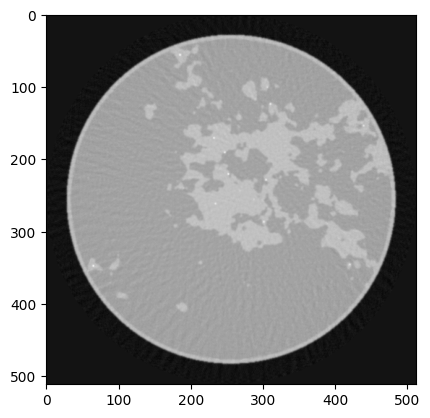

In [21]:
plt.imshow(x_[0],cmap='gray')

In [22]:
x_=x_.reshape((x_.shape[0],1,512,512))
y_=y_.reshape((y_.shape[0],1,512,512))

In [23]:
# seperating the test set from the dataset
X,x_test, Y,y_test = train_test_split(x_,y_,test_size= 0.025)

In [24]:
len(X)

2340

In [25]:
# seperating the traiining set and validation set
x_train,x_val, y_train,y_val= train_test_split(X,Y,test_size= 0.18,random_state= 42)

In [26]:
len(x_train)

1918

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
])

In [28]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [29]:
train_dataset= CustomDataset(x_train,y_train)
val_dataset= CustomDataset(x_val,y_val)
test_dataset= CustomDataset(x_test,y_test)

In [30]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=1)
test_dataloader= torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=1)

In [49]:
# class Metrics(nn.Module):
#     def training_step(self, batch):
#         images, labels = batch
#         images= images.to(device).float()
#         labels= labels.to(device).float()
#         out = self(images)                  # Generate predictions
#         ssim_loss = 1 - ssim(images, labels, data_range=1, size_average=False)
#         return ssim_loss

#     def validation_step(self, batch):
#         images, labels = batch
#         images= images.to(device).float()
#         labels= labels.to(device).float()
#         out = self(images)                    # Generate predictions
#         ssim_loss = 1 - ssim(images, labels, data_range=1, size_average=False)   # Calculate loss
#         sim =  ssim(images, labels, data_range=1, size_average=False)         # Calculate similarity
#         return {'val_loss': ssim_loss.detach(),'val_sim': sim}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_sim = [x['val_sim'] for x in outputs]
#         epoch_sim = torch.stack(batch_sim).mean()      # Combine similarities
#         return {'val_loss': epoch_loss.item(),'val_sim': epoch_sim.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_sim: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'],result['val_sim']))

In [30]:
# def bn_act(x, act=True):
#     # Batch normalization layer
#     x = nn.BatchNorm2d(x.size(1))(x)

#     if act:
#         # Activation layer (ReLU)
#         x = F.relu(x)

#     return x

In [31]:
# def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
#     # Convolutional layer with batch normalization and optional activation

#     conv = bn_act(x)
#     conv = nn.Conv2d(conv.size(1), filters, kernel_size, padding=padding, stride=strides)(conv)

#     return conv

In [32]:
# def stem(x, filters, kernel_size=3, padding='same', strides=1):
#     conv = nn.Conv2d(x.size(1), filters, kernel_size, padding=padding, stride=strides)(x)
#     conv = conv_block(conv, filters, kernel_size, padding, strides)
#     shortcut = nn.Conv2d(x.size(1), filters, kernel_size=1, padding=padding, stride=strides)(x)
#     shortcut = bn_act(shortcut, act=False)
#     output = conv + shortcut
#     return output

In [33]:
# def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
#     res = conv_block(x, filters, kernel_size, padding, strides)
#     res = conv_block(res, filters, kernel_size, padding, 1)
#     shortcut = nn.Conv2d(x.size(1), filters, kernel_size, padding=padding, stride=strides)(x)
#     shortcut = bn_act(shortcut, act=False)
#     output = shortcut + res
#     return output

In [34]:
# def upsample_concat_block(x, xskip):
#     u = F.interpolate(x, scale_factor=2, mode='nearest')
#     c = torch.cat([u, xskip], dim=1)
#     return c

In [39]:
# class ResUNet(Metrics):
#     def __init__(self, img_h, img_w):
#         super(ResUNet, self).__init__()
#         f = [16, 32, 64, 128, 256]

#         self.inputs = nn.Identity((img_h,img_w,1))

#         ## Encoder
#         self.e0 = self.inputs
#         self.e1 = stem(self.e0, f[0])
#         self.p1 = nn.Dropout(0.4)

#         self.e2 = residual_block(self.p1, f[1], strides=2)
#         self.p2 = nn.Dropout(0.4)

#         self.e3 = residual_block(self.p2, f[2], strides=2)
#         self.p3 = nn.Dropout(0.3)

#         self.e4 = residual_block(self.p3, f[3], strides=2)
#         self.p4 = nn.Dropout(0.3)

#         self.e5 = residual_block(self.p4, f[4], strides=1)

#         ## Bridge
#         self.p5 = nn.MaxPool2d(2)

#         ## Decoder
#         self.u1 = upsample_concat_block(self.p5, self.e4)
#         self.d1 = residual_block(self.u1, f[3])
#         self.p6 = nn.Dropout(0.4)

#         self.u2 = upsample_concat_block(self.p6, self.e3)
#         self.d2 = residual_block(self.u2, f[2])
#         self.p7 = nn.Dropout(0.4)

#         self.u3 = upsample_concat_block(self.p7, self.e2)
#         self.d3 = residual_block(self.u3, f[1])
#         self.p8 = nn.Dropout(0.3)

#         self.u4 = upsample_concat_block(self.d3, self.e1)
#         self.d4 = residual_block(self.u4, f[0])
#         self.p9 = nn.Dropout(0.3)

#         self.outputs = nn.Conv2d(f[0], 1, kernel_size=1, padding=0)

#     def forward(self, x):
#         x = self.inputs(x)

In [ ]:
# class ConvBlock(nn.Module):
#   def __init__(self, input_dim, output_dim, stride, padding):
#     super(ResidualConv, self).__init__()
#     self.conv_block = nn.Sequential(
#             nn.BatchNorm2d(input_dim),
#             nn.ReLU(),
#             nn.Conv2d(
#                 input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
#             ))
#     def forward(self, x):
#       return self.conv_block(x)

In [23]:
# class ResidualConv(nn.Module):
#     def __init__(self, input_dim, output_dim, stride, padding):
#         super(ResidualConv, self).__init__()

#         self.conv_block = nn.Sequential(
#             nn.BatchNorm2d(input_dim),
#             nn.ReLU(),
#             nn.Conv2d(
#                 input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
#             ),
#             nn.BatchNorm2d(output_dim),
#             nn.ReLU(),
#             nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
#         )
#         self.conv_skip = nn.Sequential(
#             nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=padding),
#             nn.BatchNorm2d(output_dim),
#         )

#     def forward(self, x):

#         return self.conv_block(x) + self.conv_skip(x)

In [41]:
# class Upsample(nn.Module):
#     def __init__(self, input_dim, output_dim, kernel, stride):
#         super(Upsample, self).__init__()

#         self.upsample = nn.ConvTranspose2d(
#             input_dim, output_dim, kernel_size=kernel, stride=stride
#         )

#     def forward(self, x):
#         return self.upsample(x)

In [100]:
# class ResUnet(Metrics):
#     def __init__(self, channel):
#         super(ResUnet, self).__init__()
#         filters=[16, 32, 64,128,256]
#         self.dropout1 = nn.Dropout(p=0.4)
#         self.dropout2 = nn.Dropout(p= 0.3)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
#         #Encoder
#         self.input_layer = nn.Sequential(
#             nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
#             nn.BatchNorm2d(filters[0]),
#             nn.ReLU(),
#             nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
#         )
#         self.input_skip = nn.Sequential(
#             nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
#         )

#         self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, padding=1)
#         self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, padding=1)
#         self.residual_conv_3 = ResidualConv(filters[2], filters[3], 2, padding=1)

#         self.bridge = ResidualConv(filters[3], filters[4], 1, padding=1)
#        #Decoder

#         self.upsample_1 = Upsample(filters[4], filters[4], 2, 2)
#         self.up_residual_conv1 = ResidualConv(filters[4]+filters[3], filters[3], 1, padding=1)

#         self.upsample_2 = Upsample(filters[3], filters[3], 2, 1)
#         self.up_residual_conv2 = ResidualConv(filters[3]+filters[2] , filters[2], 1, padding=1)

#         self.upsample_3 = Upsample(filters[2], filters[2], 2,1)
#         self.up_residual_conv3 = ResidualConv(filters[2]+filters[1] , filters[1], 1, padding=1)

#         self.upsample_4 = Upsample(filters[1], filters[1], 2,1)
#         self.up_residual_conv4 = ResidualConv(filters[1]+filters[0] , filters[0], 1, padding=1)

#         self.output_layer = nn.Sequential(
#             nn.Conv2d(filters[0], 1, 1, padding=1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         # Encode
#         x1 = self.input_layer(x) + self.input_skip(x)
#         x1= self.dropout1(x1)

#         x2 = self.residual_conv_1(x1)
#         x2 = self.dropout1(x2)

#         x3 = self.residual_conv_2(x2)
#         x3 = self.dropout2(x3)

#         x4 = self.residual_conv_3(x3)
#         x4 = self.dropout2(x4)
#         # Bridge
#         # x5 = self.bridge(x4)
#         # x5= self.maxpool(x5)
#         # Decode
#         x5 = self.upsample_1(x4)
#         x6 = torch.cat([x5, x4], dim=1)
#         x7 = self.up_residual_conv1(x6)

#         x7 = self.upsample_2(x7)
#         x8 = torch.cat([x7, x3], dim=1)
#         x9 = self.up_residual_conv2(x8)

#         x9 = self.upsample_3(x9)
#         x10 = torch.cat([x9, x2], dim=1)
#         x11 = self.up_residual_conv3(x10)

#         x11 = self.upsample_4(x11)
#         x12 = torch.cat([x11, x1], dim=1)
#         output = self.output_layer(x12)

#         # output = x-output

#         return output

In [29]:
# RESUNET
class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=padding),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class ResUnet(nn.Module):
    def __init__(self, channel):
        super(ResUnet, self).__init__()
        filters=[32, 64, 128,256,512]
        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p= 0.3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        #Encoder
        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, padding=1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, padding=1)
        self.residual_conv_3 = ResidualConv(filters[2], filters[3], 2, padding=1)
        self.residual_conv_4 = ResidualConv(filters[3], filters[4], 2, padding=1)

        self.upsample_1 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.up_residual_conv1 = ResidualConv(filters[4] , filters[3], 1, padding=1)
        self.upsample_2 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.up_residual_conv2 = ResidualConv(filters[3] , filters[2], 1, padding=1)
        self.upsample_3 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.up_residual_conv3 = ResidualConv(filters[2] , filters[1], 1, padding=1)
        self.upsample_4 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.up_residual_conv4 = ResidualConv(filters[1] , filters[0], 1, padding=1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x)
        x1 = self.dropout1(x1)

        x2 = self.residual_conv_1(x1)
        x2 = self.dropout1(x2)

        x3 = self.residual_conv_2(x2)
        x3 = self.dropout1(x3)

        x4 = self.residual_conv_3(x3)
        x4 = self.dropout1(x4)

        x5 = self.residual_conv_4(x4)
        x5 = self.dropout1(x5)

        # Decode
        x6 = self.upsample_1(x5)
        x6 = torch.cat([x6, x4], dim=1)
        x6 = self.up_residual_conv1(x6)
        x6 = self.dropout1(x6)

        x7 = self.upsample_2(x6)
        x7 = torch.cat([x7, x3], dim=1)
        x7 = self.up_residual_conv2(x7)
        x7 = self.dropout1(x7)

        x8 = self.upsample_3(x7)
        x8 = torch.cat([x8, x2], dim=1)
        x8 = self.up_residual_conv3(x8)
        x8 = self.dropout1(x8)

        x9 = self.upsample_4(x8)
        x9 = torch.cat([x9, x1], dim=1)
        x9 = self.up_residual_conv4(x9)
        x9 = self.dropout1(x9)
        output = self.output_layer(x9)
        output= x-output
        return output

In [31]:
# FBP Conv NET
class FirstBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstBlock, self).__init__()
        self.convblock= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
        )

    def forward(self, x):
        return self.convblock(x)

class convBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(convBlock, self).__init__()
        self.convblock= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
      )
    def forward(self,x):
        return self.convblock(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock,self).__init__()
        self.convblock= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
         )
    def forward(self,x):
        return self.convblock(x)

class UPSample(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(UPSample,self).__init__()
        self.upsampl= nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
        )
    def forward(self,x):
        return self.upsampl(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.input_layer= FirstBlock(in_channels,64)
        self.down1= convBlock(64,128)
        self.down2= convBlock(128,256)
        self.down3= convBlock(256,512)
        self.down4= nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=False),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=False),
        )
        self.dropout= nn.Dropout(p=0.4)
        self.mp= nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample_1 = UPSample(1024, 512)
        self.up_conv1= UpBlock(1024,512)
        self.upsample_2 = UPSample(512,256)
        self.up_conv2= UpBlock(512,256)
        self.upsample_3 = UPSample(256,128)
        self.up_conv3 = UpBlock(256,128)
        self.upsample_4 = UPSample(128,64)
        self.up_conv4 = UpBlock(128,64)

        self.convf = nn.Sequential(
             nn.Conv2d(64, out_channels, kernel_size=1,padding =0),
             nn.Sigmoid()
        )
        self.res= nn.Conv2d(2,1,kernel_size=1,padding =0)
    def forward(self,x):
        x1= self.input_layer(x)
        x1_1= self.mp(x1)
        x1_1 = self.dropout(x1_1)
        
        x2= self.down1(x1_1)
        x2_2= self.mp(x2)
        x2_2= self.dropout(x2_2)
        
        x3= self.down2(x2_2)
        x3_3= self.mp(x3)
        x3_3= self.dropout(x3_3)
        
        x4= self.down3(x3_3)
        x4_4= self.mp(x4)
        x4_4= self.dropout(x4_4)
        
        x5= self.down4(x4_4)
        x5= self.dropout(x5)
        
        x6 = self.upsample_1(x5)
        x6 = torch.cat([x6, x4], dim=1)
        x6 = self.up_conv1(x6)
        x6 = self.dropout(x6)
        
        x7 = self.upsample_2(x6)
        x7 = torch.cat([x7,x3],dim=1)
        x7 = self.up_conv2(x7)
        x7 = self.dropout(x7)
        
        x8 = self.upsample_3(x7)
        x8 = torch.cat([x8, x2],dim=1)
        x8 = self.up_conv3(x8)
        x8 = self.dropout(x8)

        x9 = self.upsample_4(x8)
        x9 = torch.cat([x9,x1],dim=1)
        x9 = self.up_conv4(x9)
        x9 = self.dropout(x9)

        x10 = self.convf(x9)
        x10 = torch.cat([x10,x],dim=1)
        x10 = self.res(x10)

        return x10

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
device

device(type='cuda')

In [36]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [35]:
model= UNet(1,1)

In [37]:
model.to(device)

DataParallel(
  (module): UNet(
    (input_layer): FirstBlock(
      (convblock): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      )
    )
    (down1): convBlock(
      (convblock): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [38]:
summary(model, input_size=(1, 512, 512))

Layer (type:depth-idx)                        Param #
├─UNet: 1-1                                   --
|    └─FirstBlock: 2-1                        --
|    |    └─Sequential: 3-1                   74,880
|    └─convBlock: 2-2                         --
|    |    └─Sequential: 3-2                   221,952
|    └─convBlock: 2-3                         --
|    |    └─Sequential: 3-3                   886,272
|    └─convBlock: 2-4                         --
|    |    └─Sequential: 3-4                   3,542,016
|    └─Sequential: 2-5                        --
|    |    └─Conv2d: 3-5                       4,719,616
|    |    └─BatchNorm2d: 3-6                  2,048
|    |    └─ReLU: 3-7                         --
|    |    └─Conv2d: 3-8                       9,438,208
|    |    └─BatchNorm2d: 3-9                  2,048
|    |    └─ReLU: 3-10                        --
|    └─Dropout: 2-6                           --
|    └─MaxPool2d: 2-7                         --
|    └─UPSample: 2-8   

Layer (type:depth-idx)                        Param #
├─UNet: 1-1                                   --
|    └─FirstBlock: 2-1                        --
|    |    └─Sequential: 3-1                   74,880
|    └─convBlock: 2-2                         --
|    |    └─Sequential: 3-2                   221,952
|    └─convBlock: 2-3                         --
|    |    └─Sequential: 3-3                   886,272
|    └─convBlock: 2-4                         --
|    |    └─Sequential: 3-4                   3,542,016
|    └─Sequential: 2-5                        --
|    |    └─Conv2d: 3-5                       4,719,616
|    |    └─BatchNorm2d: 3-6                  2,048
|    |    └─ReLU: 3-7                         --
|    |    └─Conv2d: 3-8                       9,438,208
|    |    └─BatchNorm2d: 3-9                  2,048
|    |    └─ReLU: 3-10                        --
|    └─Dropout: 2-6                           --
|    └─MaxPool2d: 2-7                         --
|    └─UPSample: 2-8   

In [39]:
# torch.cuda.list_gpu_processes(device=None)
# torch.cuda.mem_get_info(device=None)
# torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.memory_allocated(device=None)

158611968

In [37]:
!pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.0 MB/s eta 0:00:00


In [40]:
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter to track epochs without improvement

In [44]:
# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func):
#     history = []
#     optimizer = opt_func(model.parameters(), lr)
#     for epoch in range(epochs):
#         # Training Phase
#         model.train()
#         train_losses = []
#         for batch in train_loader:
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#         # Validation phase
#         result = evaluate(model, val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
#         model.epoch_end(epoch, result)
#         history.append(result)

#         if result['val_loss'] < best_val_loss:
#             best_val_loss = result['val_loss']
#             counter = 0
#             torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
#         else:
#             counter += 1
#             if counter >= patience:
#                 print("Early stopping triggered. Best validation loss: {:.4f}".format(best_val_loss))
#                 break
#         return history

In [41]:
epochs = 60
opt_func = torch.optim.Adam(model.parameters(),lr=0.001)
lr = 0.01

In [ ]:
# def fit(epochs, lr, model, train_loader, val_loader, opt_func):
st_time= time.perf_counter()
optimizer = opt_func
train_loss=[]
val_loss=[]
val_similarity=[]
result= dict()
for epoch in range(epochs):
    train_losses=[]
    val_losses=[]
    val_sim=[]
    model.train()
    for batch in train_dataloader:
        images, targets = batch
        images = images.to(device).float()
        targets = targets.to(device).float()

      # Forward pass
        output = model(images)
      # output = output.permute(1, 0, 2, 3)
        loss = 1 - ssim(output, targets, data_range=1, size_average=True)  # Example loss function (replace with your own)

      # Compute gradients and update weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss)
    train_loss.append(torch.stack(train_losses).mean())
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            images, targets = batch
            images = images.to(device).float()
            targets = targets.to(device).float()

          # Forward pass
            output = model(images)
            loss = 1 - ssim(output, targets, data_range=1, size_average=True)  # Example loss function (replace with your own)
            val_sim.append(1-loss)
            val_losses.append(loss)
    val_loss.append(torch.stack(val_losses).mean())
    val_similarity.append(torch.stack(val_sim).mean())
  # result['val_loss']= torch.stack(val_losses).mean()
  # result['val_similarity']= torch.stack(val_sim).mean()
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_sim: {:.4f}".format(
        epoch, train_loss[-1], val_loss[-1],val_similarity[-1]))
end_time= time.perf_counter
# ex_time= end_time-st_time
# print("The time for Training: ",ex_time)

Epoch [0], train_loss: 0.4476, val_loss: 0.3772, val_sim: 0.6228
Epoch [1], train_loss: 0.3764, val_loss: 0.3712, val_sim: 0.6288
Epoch [2], train_loss: 0.3696, val_loss: 0.3642, val_sim: 0.6358
Epoch [3], train_loss: 0.3619, val_loss: 0.3570, val_sim: 0.6430
Epoch [4], train_loss: 0.3541, val_loss: 0.3492, val_sim: 0.6508
Epoch [5], train_loss: 0.0925, val_loss: 0.0017, val_sim: 0.9983
Epoch [6], train_loss: 0.0024, val_loss: 0.0012, val_sim: 0.9988
Epoch [7], train_loss: 0.0022, val_loss: 0.0014, val_sim: 0.9986
Epoch [8], train_loss: 0.0022, val_loss: 0.0014, val_sim: 0.9986
Epoch [9], train_loss: 0.0021, val_loss: 0.0011, val_sim: 0.9989
Epoch [10], train_loss: 0.0021, val_loss: 0.0010, val_sim: 0.9990
Epoch [11], train_loss: 0.0021, val_loss: 0.0011, val_sim: 0.9989
Epoch [12], train_loss: 0.0020, val_loss: 0.0014, val_sim: 0.9986
Epoch [13], train_loss: 0.0020, val_loss: 0.0013, val_sim: 0.9987
Epoch [14], train_loss: 0.0020, val_loss: 0.0011, val_sim: 0.9989
Epoch [15], train_lo

In [1]:
print((end_time()-st_time)/60)

NameError: name 'end_time' is not defined

In [2]:
t_loss= np.zeros((epochs))
v_loss= np.zeros((epochs))
for i in range(epochs):
    t_loss[i]= train_loss[i].cpu().detach().numpy()
    v_loss[i]= val_loss[i].cpu().detach().numpy()

NameError: name 'np' is not defined

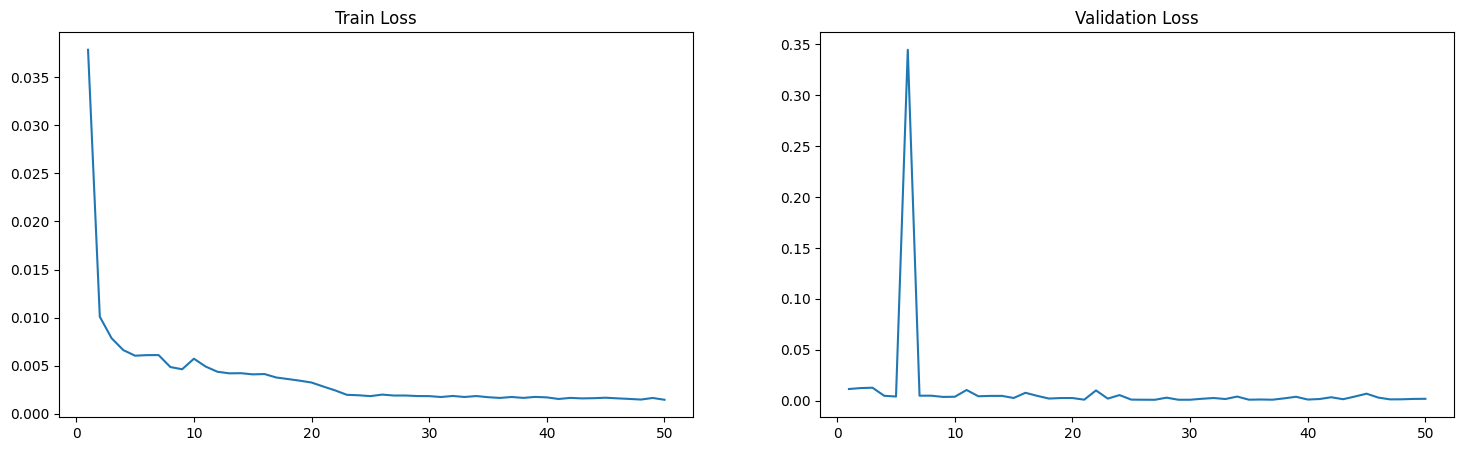

In [65]:
fig,axs= plt.subplots(1,2,figsize=(18,5))
axs[0].plot(np.arange(1,51),t_loss)
axs[0].set_title("Train Loss")

axs[1].plot(np.arange(1,51),v_loss)
axs[1].set_title("Validation Loss")

plt.show()

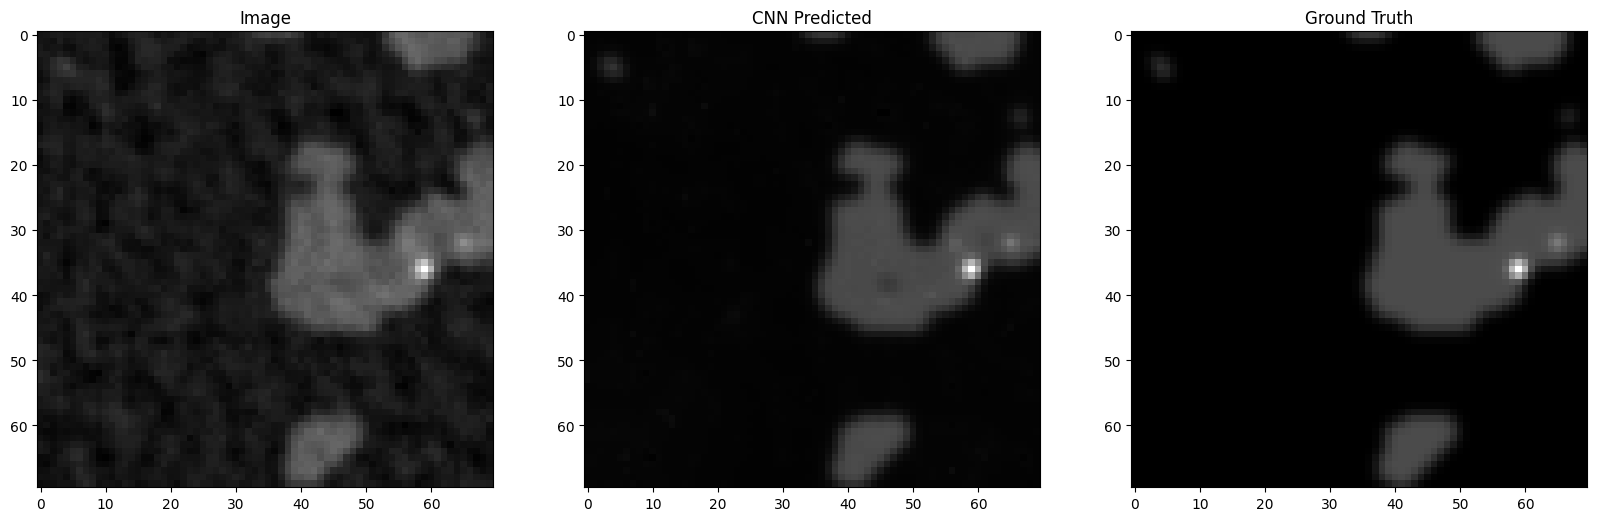

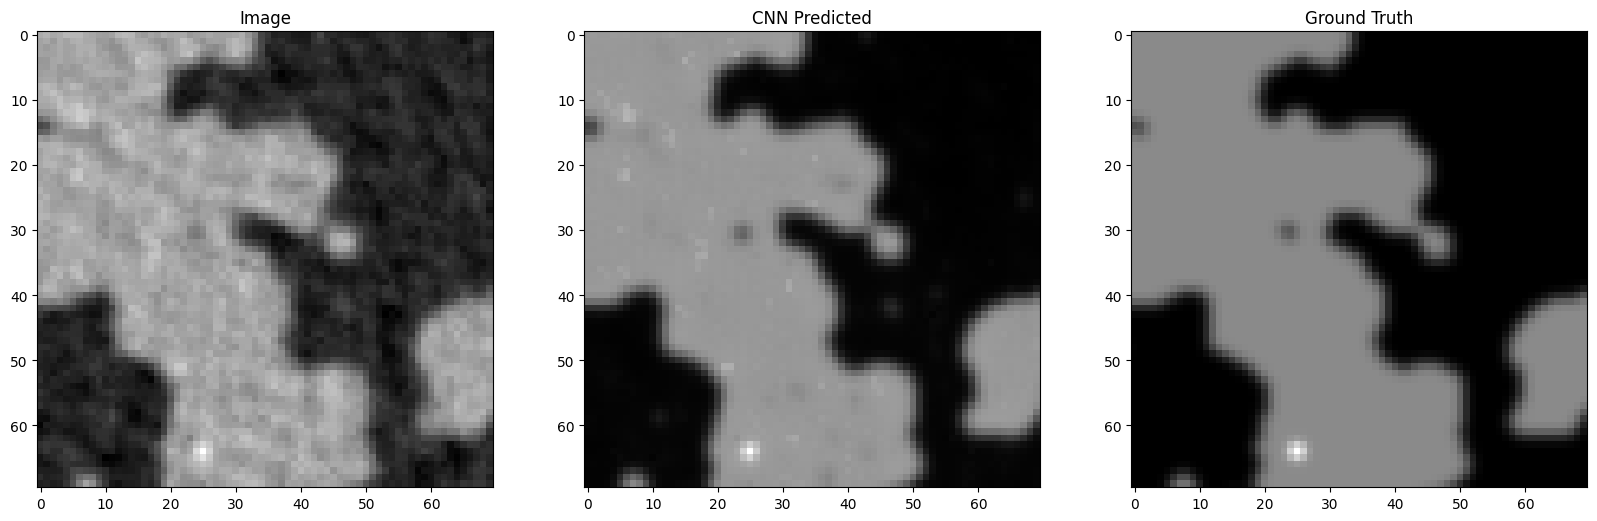

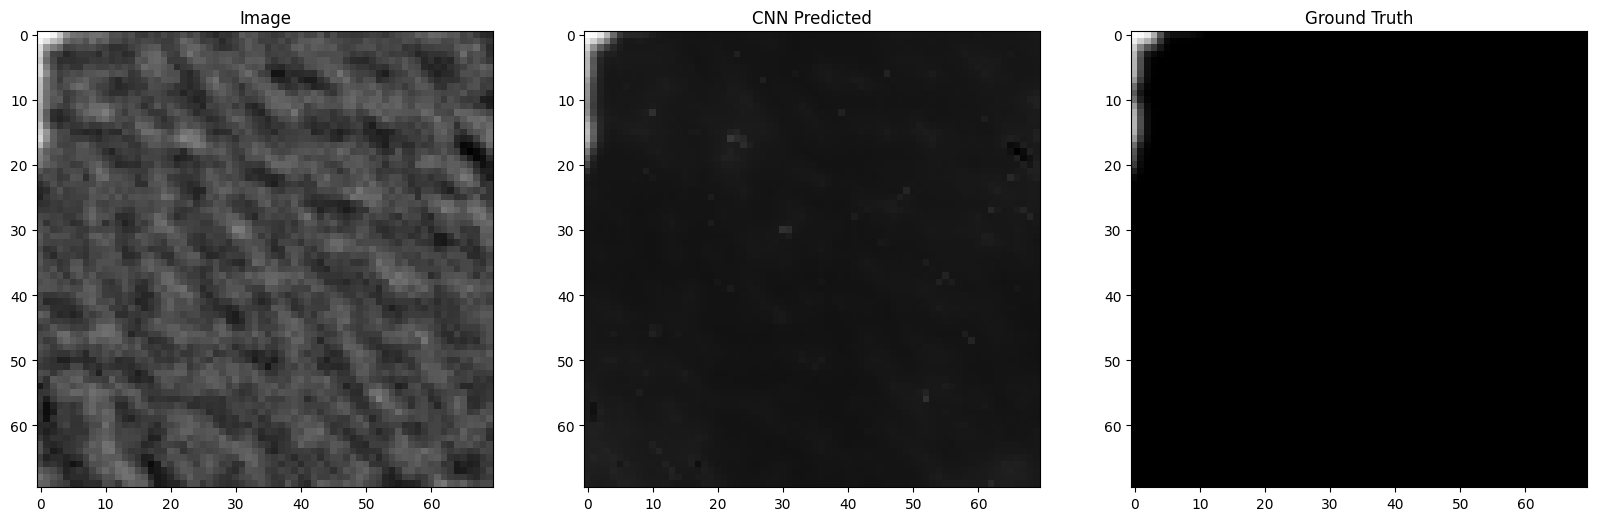

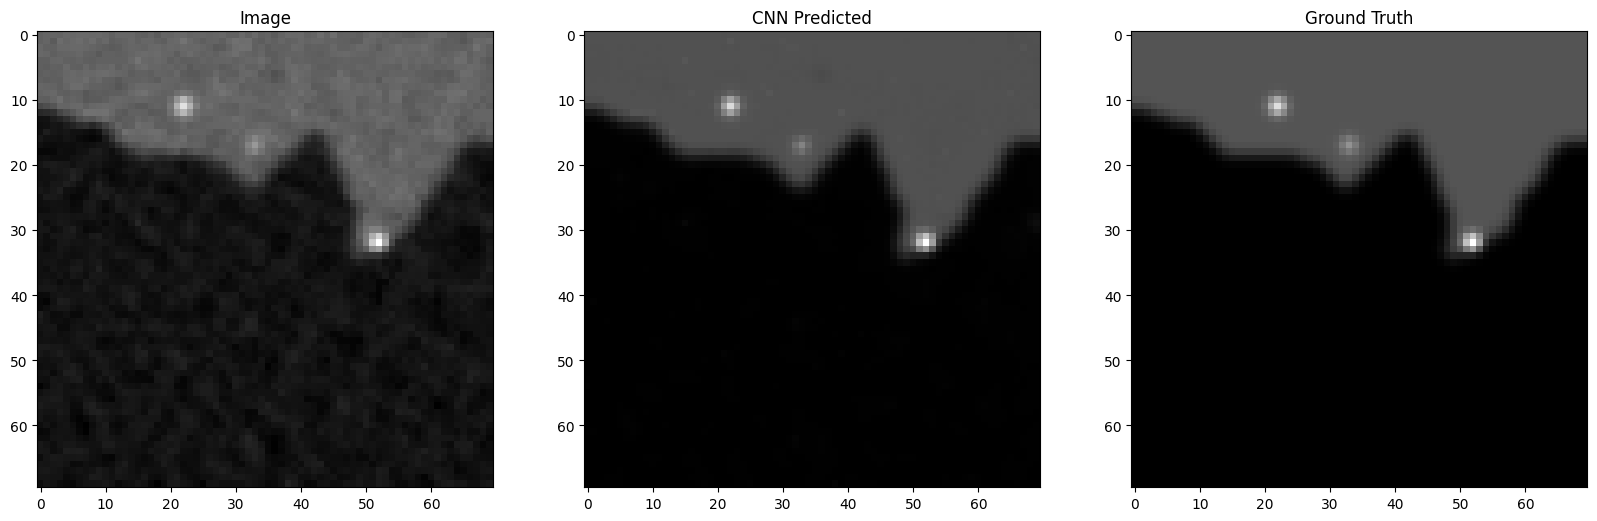

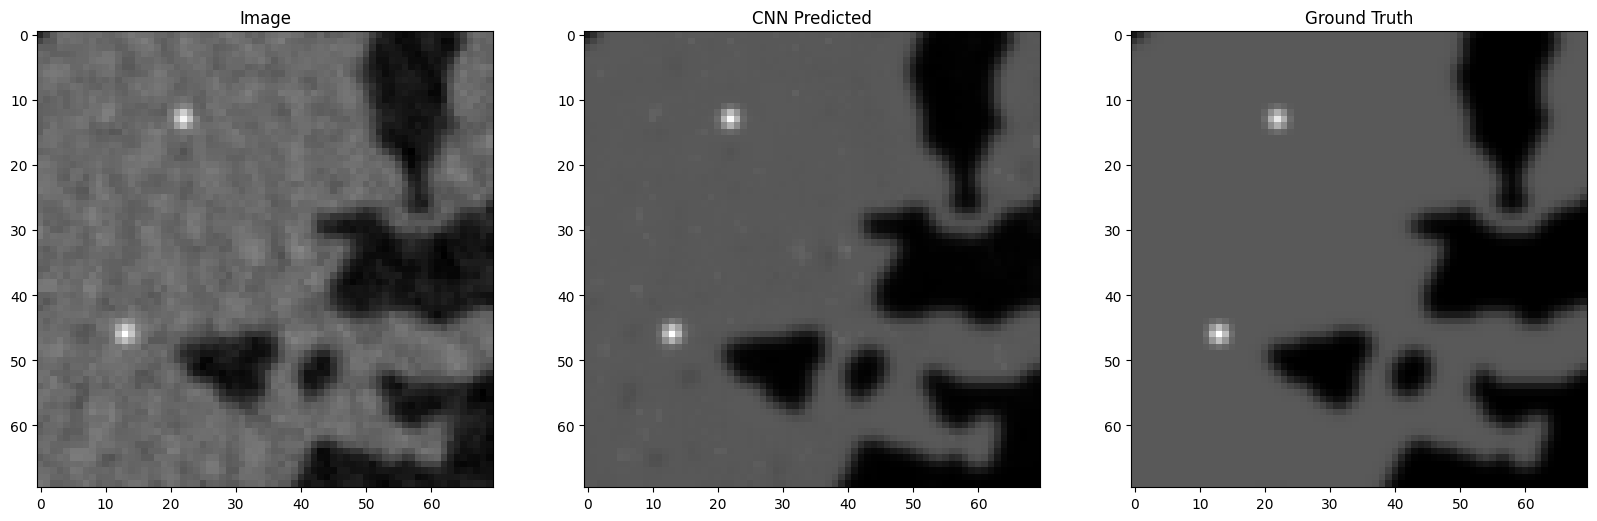

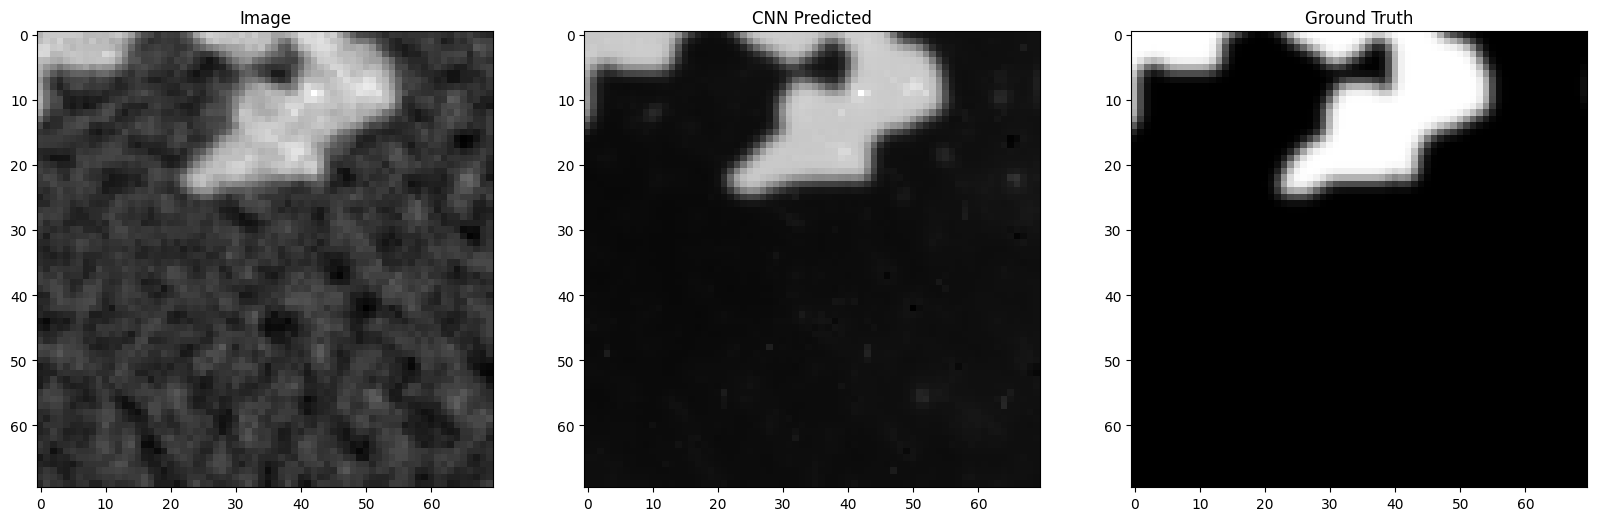

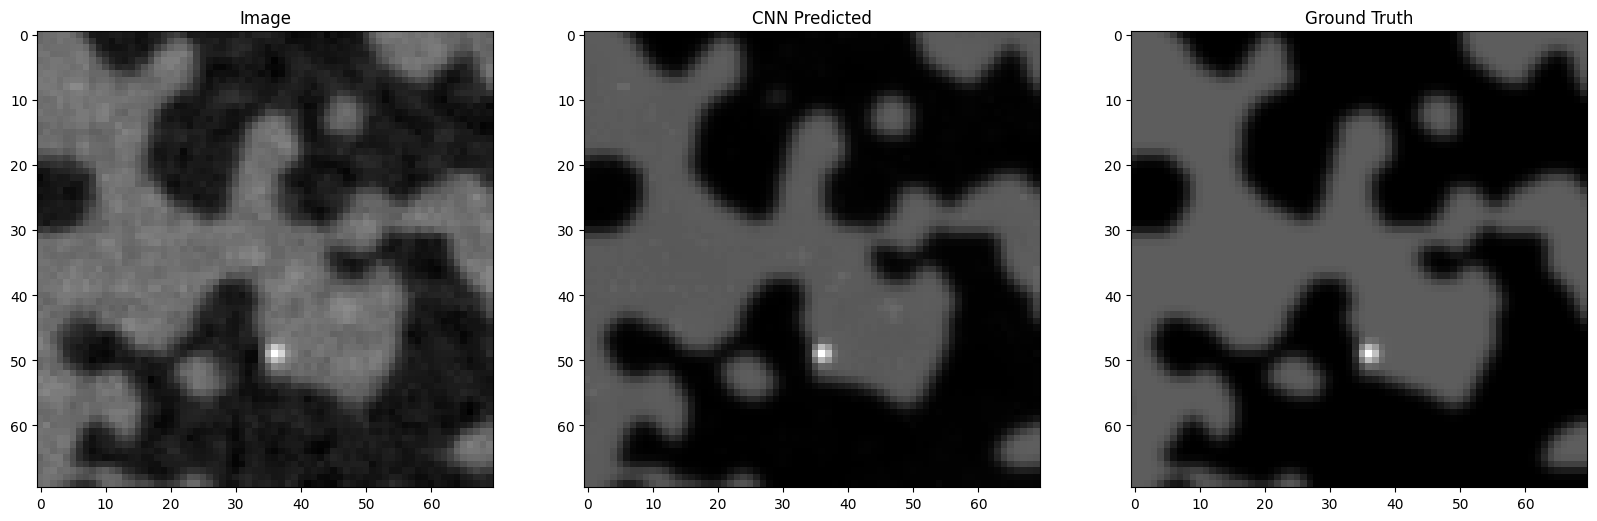

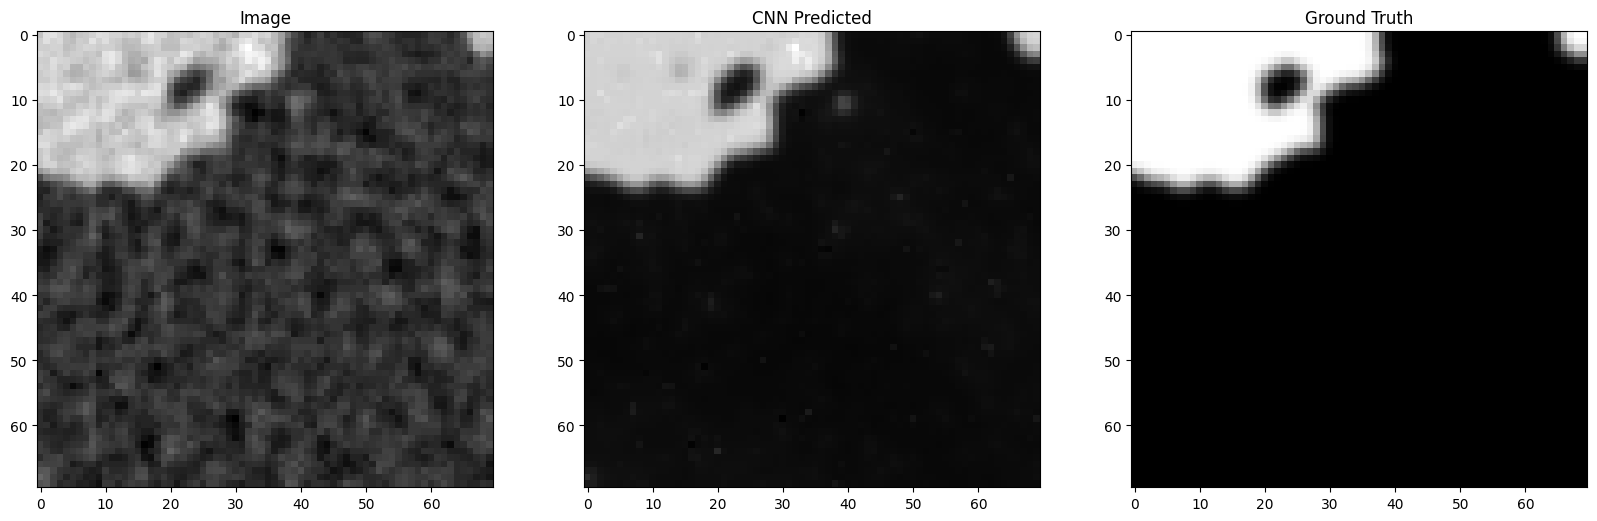

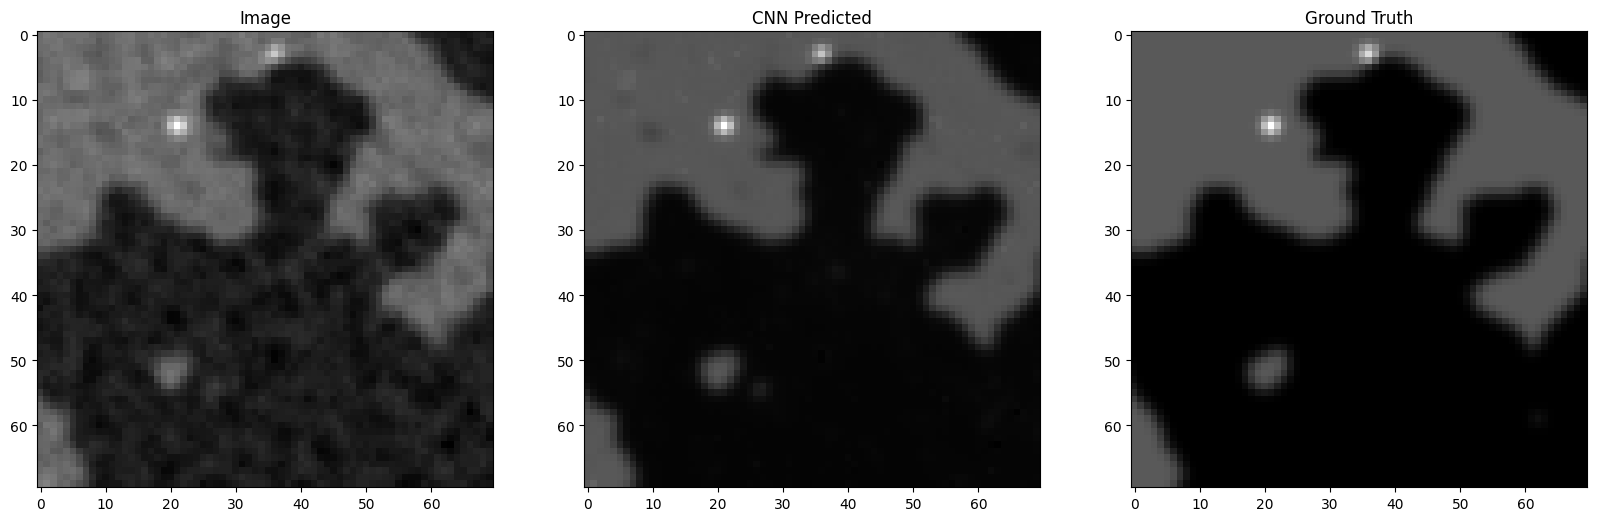

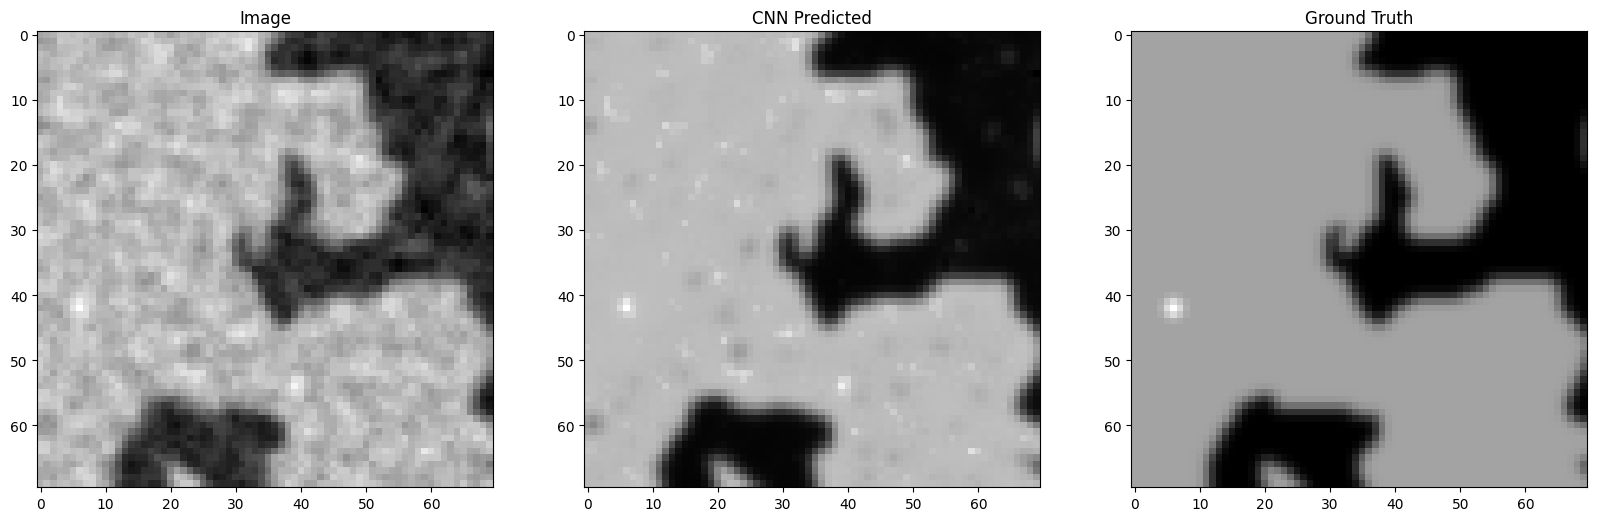

In [71]:
with torch.no_grad():
    for batch in test_dataloader:
        images, targets = batch
        i= images
        t= targets
        images = images.to(device).float()
    # targets = targets.to(device).float()
        outputs= model(images)
        outputs= outputs.permute(0,2,3,1)
        
    # outputs= torch.squeeze(outputs.permute(0,2,3,1),dim=0)
        _, y_pred = torch.max(outputs.data, 1)
#         for a in range(len(i)):
#             print(outputs[a].max())
        i= i.permute(0,2,3,1)
        t= t.permute(0,2,3,1)
        j= torch.squeeze(i,dim=0)
        for a in range(len(i)//4):
#             p
#             outputs_np= outputs[a].cpu().numpy()
#             histogram = cv2.calcHist([outputs_np], [0], None, [2], [0, 2])
#             plt.figure()
#             plt.title('Histogram')
#             plt.xlabel('Pixel Value')
#             plt.ylabel('Frequency')
#             plt.plot(histogram[0:2])
#             plt.show()
# #             outputs_np = (outputs_np - np.min(outputs_np)) * 128 / (np.max(outputs_np) - np.min(outputs_np))
#             outputs_np = outputs_np.astype(np.uint8)*1000
            
# #             out= cv2.equalizeHist(outputs_np)
            fig, ax = plt.subplots(1, 3, figsize=(20, 10))
            ax[0].imshow(i[a][280:350,250:320],cmap='gray')


            ax[0].set_title('Image')

            ax[1].imshow(outputs[a].cpu()[280:350,250:320],cmap='gray')
            ax[1].set_title('CNN Predicted')

            ax[2].imshow(t[a][280:350,250:320],cmap='gray')
            ax[2].set_title('Ground Truth')

In [68]:
def calculate_rmse(image1, image2):
    image1_array = np.array(image1)
    image2_array = np.array(image2)
    
    image1_flat = image1_array.flatten()
    image2_flat = image2_array.flatten()
    
    mse = mean_squared_error(image1_flat, image2_flat)
    rmse = np.sqrt(mse)
    
    return rmse

In [69]:
s1=[]
# s2=[]
r1=[]
# r2=[]

with torch.no_grad():
    for batch in test_dataloader:
        images, targets = batch
        i= images
        t= targets
        images = images.to(device).float()
        targets = targets.to(device).float()
        outputs= model(images)
#         outputs= outputs.permute(0,2,3,1)
#         outputs= outputs.cpu().detach.numpy()
    # outputs= torch.squeeze outputs.permute(0,2,3,1),dim=0)
        i= i.permute(0,2,3,1)
        t= t.permute(0,2,3,1)
        j= torch.squeeze(i,dim=0)
        sim= ssim(outputs, targets, data_range=1, size_average=True)
        s1.append(sim.cpu())
        
        mse= torch.mean((outputs-targets)**2,dim=(1,2,3))
        rmse= torch.sqrt(torch.mean(mse))
        r1.append(rmse.cpu())
#         for a in range(len(i)):
            
#             score1= ssim(outputs[a].unsqueeze(dim=0), targets[a].permute(1,2,0).unsqueeze(), data_range=1, size_average=False)
#             score2= calculate_rmse(outputs[a],targets[a])
#             s1.append(score1)
#             r1.append(score2)
# t1= np.array(s1)
# u1= np.array(r1)
# print("The average SSIM between the groundtruth and the reconstructed images is :",np.mean(t1))
# print("The average RMSE between the groundtruth and the reconstructed images is :",np.mean(u1))


In [70]:
t1= np.zeros((len(s1)))
u1=np.zeros((len(r1)))
for i in range(len(t1)):
    t1[i]=s1[i].numpy()
    u1[i]=r1[i].numpy()
print("The average SSIM between the groundtruth and the reconstructed images is :",np.mean(t1))
print("The average RMSE between the groundtruth and the reconstructed images is :",np.mean(u1))

The average SSIM between the groundtruth and the reconstructed images is : 0.9982177555561066
The average RMSE between the groundtruth and the reconstructed images is : 0.0013614732073619963


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
def plot_similarity(history):
    similarity = [x['val_acc'] for x in history]
    plt.plot(similarity, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_similarity(history)

In [10]:
# torch.tensor((8,1,256,256)).permute(0,2,3,1)

RuntimeError: ignored